In [1]:
import os
import sys
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import the Modules dir
project_path = "<PATH-TO-REPO>/BiMAEB-UDD-RUL/"
sys.path.insert(0, project_path)

from Modules.Models import RULNeuralNetwork
from experimental_results.functions import (normalize_df,
                                            view_RUL_stats,
                                            view_performance_on_data,
                                            get_model_rul_predictions,
                                            get_scores,
                                            get_mse,
                                            plot_unit_recon_error_and_threshold,
                                            plot_rul_predictions_and_targets,
                                            normalize_df_with_context,
                                            TURBOFAN_FEATURES_LIST)

In [2]:
normal_op_len = 45
norm_op_len_as_pct = True

dataset = "FD003"
model_type = "AE"
prefix = "Pct" if norm_op_len_as_pct else "Len"

print(f"Normality: {normal_op_len} {prefix}")

Normality: 45 Pct


In [3]:
model_name = f"normOp{prefix}{normal_op_len}_RUL_{model_type}"

path_to_training_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/train"
path_to_testing_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/validation"

# Define file names
csv_file_training = f"{dataset}_train_unsupervised_labels_AutoEncoder_Op{prefix}{normal_op_len}.csv"
csv_file_testing = f"{dataset}_test_unsupervised_labels_AutoEncoder_Op{prefix}{normal_op_len}.csv"

# Define paths
dataset_path_training = os.path.join(path_to_training_data_dir, csv_file_training)
dataset_path_testing = os.path.join(path_to_testing_data_dir, csv_file_testing)

path_to_model_state_dict = f"models/{model_name}_model_state_dict"

print(f"Model Path: {path_to_model_state_dict}")

Model Path: models/normOpPct45_RUL_AE_model_state_dict


In [4]:
# Read original data
print(f"Reading dataset: \n{dataset_path_testing}\n")
print(f"Reading dataset: \n{dataset_path_training}")

df_testing_not_normalized = pd.read_csv(dataset_path_testing)
df_training_not_normalized = pd.read_csv(dataset_path_training)

Reading dataset: 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation/FD003_test_unsupervised_labels_AutoEncoder_OpPct45.csv

Reading dataset: 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train/FD003_train_unsupervised_labels_AutoEncoder_OpPct45.csv


In [5]:
print("Normalizing datasets...\n")

# Normalize testing data using training data as the context.
df_testing_normalized = normalize_df_with_context(df=df_testing_not_normalized,
                                                  df_context=df_training_not_normalized,
                                                  model_features=TURBOFAN_FEATURES_LIST)

df_training_normalized = normalize_df(df_training_not_normalized, TURBOFAN_FEATURES_LIST)

Normalizing datasets...



In [6]:
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device: {}".format(device))

Using Device: cpu


In [7]:
window_size = 1
metrics_dir = "model"
ts_number_features = len(TURBOFAN_FEATURES_LIST)
latent_size = 16

print(f"Normality Length: {normal_op_len}")
print(f"Latent Size: {latent_size}")
print(f"Number ts features: {ts_number_features}")

Normality Length: 45
Latent Size: 16
Number ts features: 24


In [9]:
model = RULNeuralNetwork(ts_number_features=ts_number_features,
                         device=device,
                         model_name="",
                         metrics_dir=metrics_dir)

print(f"Reading model at '{path_to_model_state_dict}'")
model.load_state_dict(torch.load(path_to_model_state_dict, map_location=torch.device(device)))

Reading model at 'models/normOpPct45_RUL_AE_model_state_dict'


<All keys matched successfully>

In [10]:
view_performance_on_data(model=model, 
                         df=df_testing_normalized, 
                         identifier_col="unit", 
                         cycle_col="cycle", 
                         rul_col="RUL", 
                         fault_col="fault",
                         show_anomalies_only=True,
                         show_scores=True)

Computing RUL for Unit 3 (on cycle=234)
Target: 27 --> Pred.:  30
MSE=7.73
Score=0.24

Computing RUL for Unit 5 (on cycle=138)
Target: 101 --> Pred.:  199
MSE=9635.32
Score=1901.16

Computing RUL for Unit 14 (on cycle=169)
Target: 31 --> Pred.:  40
MSE=81.80
Score=1.01

Computing RUL for Unit 16 (on cycle=126)
Target: 56 --> Pred.:  169
MSE=12752.62
Score=5922.79

Computing RUL for Unit 18 (on cycle=244)
Target: 132 --> Pred.:  164
MSE=1042.63
Score=10.99

Computing RUL for Unit 21 (on cycle=263)
Target: 18 --> Pred.:  32
MSE=188.31
Score=1.87

Computing RUL for Unit 22 (on cycle=119)
Target: 119 --> Pred.:  88
MSE=944.67
Score=20.62

Computing RUL for Unit 23 (on cycle=405)
Target: 78 --> Pred.:  73
MSE=26.81
Score=0.68

Computing RUL for Unit 24 (on cycle=475)
Target: 9 --> Pred.:  9
MSE=0.00
Score=0.01

Computing RUL for Unit 25 (on cycle=169)
Target: 58 --> Pred.:  52
MSE=30.27
Score=0.73

Computing RUL for Unit 26 (on cycle=130)
Target: 11 --> Pred.:  22
MSE=112.49
Score=1.26

Com

In [12]:
list(df_testing_normalized.query("fault==1")["unit"].unique())

[3,
 5,
 14,
 16,
 18,
 21,
 22,
 23,
 24,
 25,
 26,
 30,
 33,
 39,
 40,
 46,
 48,
 49,
 50,
 64,
 71,
 76,
 78,
 79,
 81,
 82,
 86,
 89,
 90,
 92,
 94,
 96,
 98,
 99,
 100]

Predicted 28 Samples in unit 40
Score: 30.258507311892476
MSE: 86.75045521769373


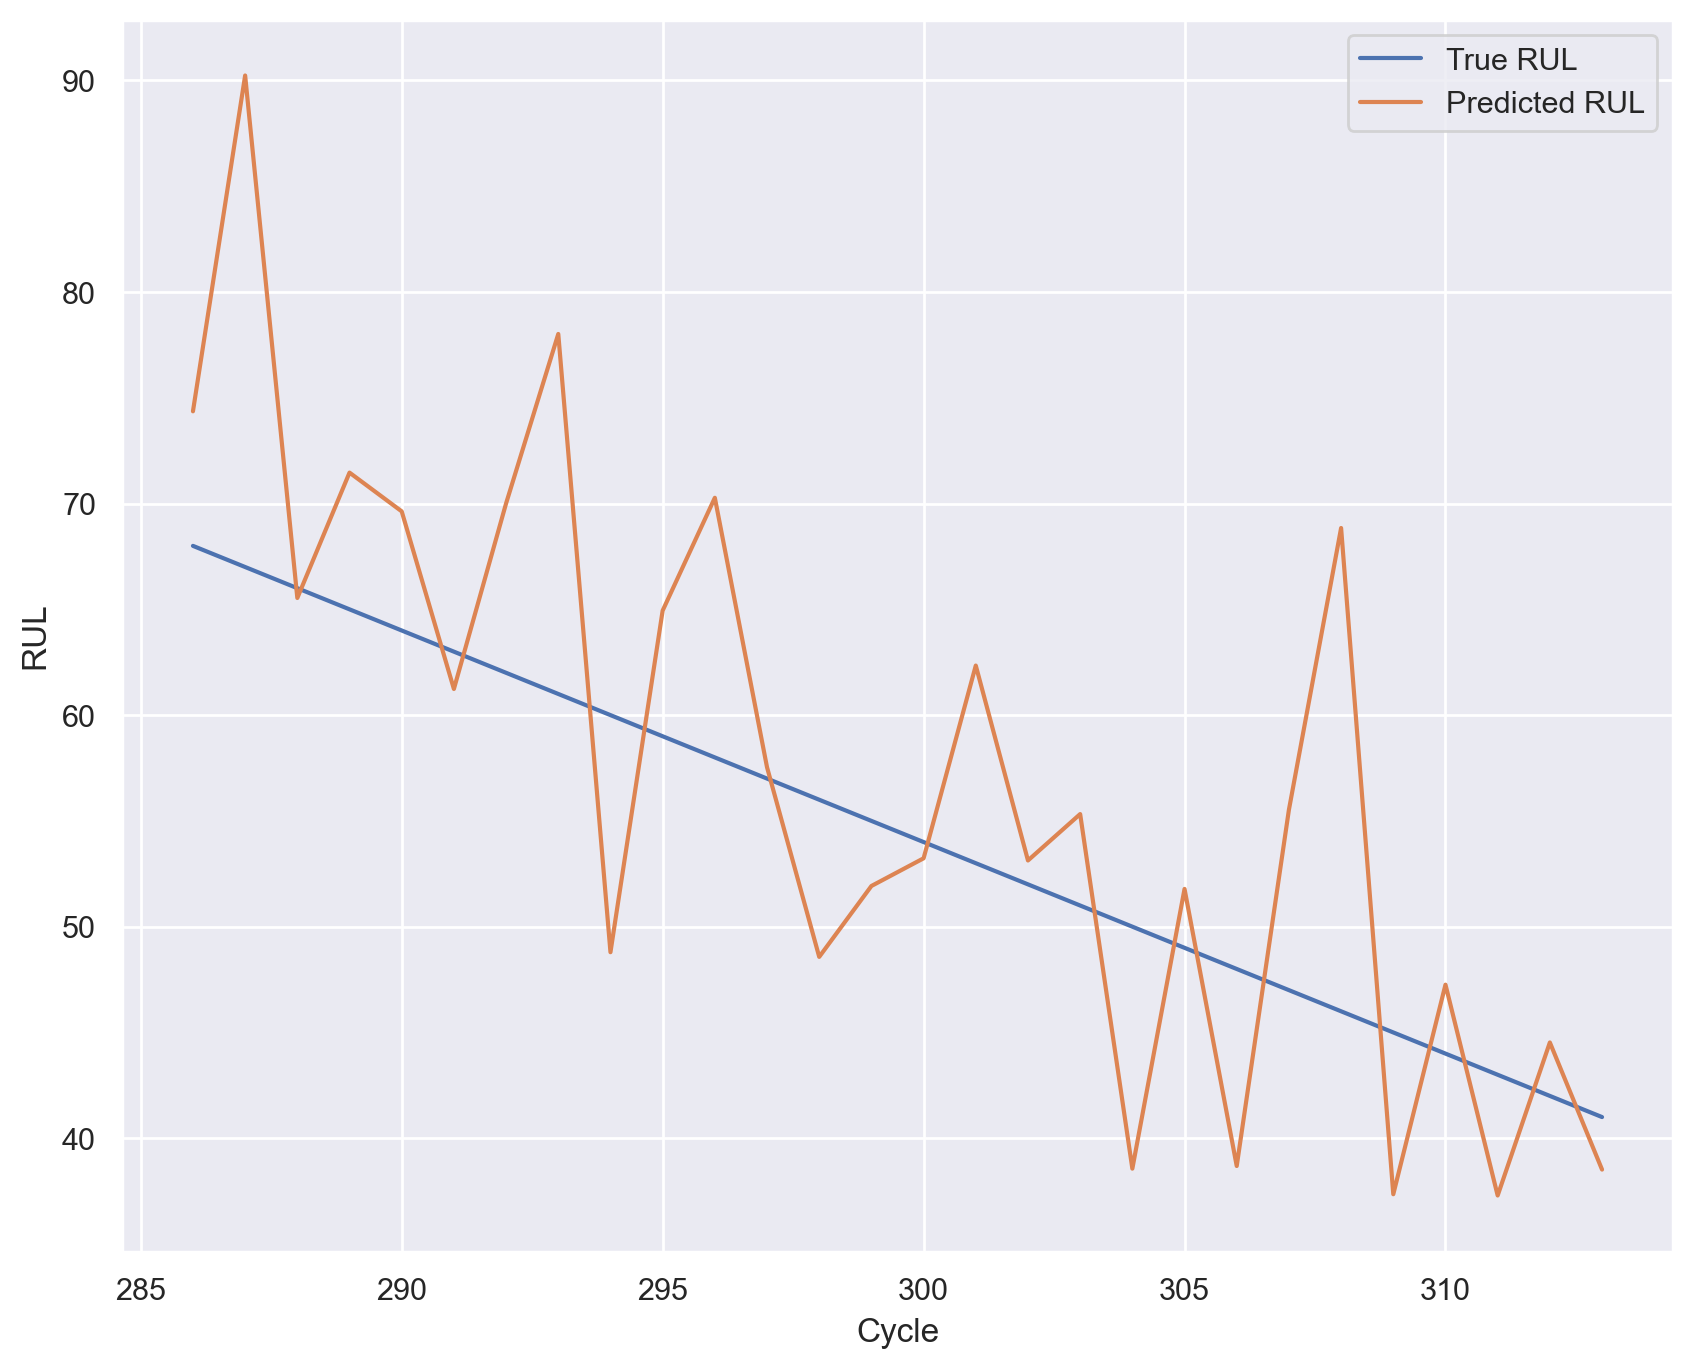

In [17]:
unit = 40
query_faults = True

df_unit = df_testing_normalized.query(f"unit=={unit}")
if query_faults:
    df_unit = df_unit.query("fault==1")
features = df_unit[TURBOFAN_FEATURES_LIST].to_numpy()
targets = df_unit["RUL"].to_numpy()
cycles = df_unit["cycle"].to_numpy()

rul_predictions = get_model_rul_predictions(model, features)
print(f"Predicted {len(rul_predictions)} Samples in unit {unit}")
plot_rul_predictions_and_targets(rul_predictions, targets=targets, cycles=cycles)